In [80]:
#Part 1- Classify all symbols

#Load packages

#%pip install --upgrade pip

%pip install -q numpy emnist pandas matplotlib seaborn scikit-learn tensorflow xgboost

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import tensorflow
import xgboost
import emnist
from IPython.display import display, Markdown


# ML packages
# Random Forest
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
# Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
# XGBoost (SVM)
from xgboost import XGBClassifier
# Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

# Constants
SIZE = 28
REBUILD = True
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' # or 3 to suppress all warnings

#%reset -f

Note: you may need to restart the kernel to use updated packages.


In [85]:
# Define helper functions
def int_to_char(label):
    """Convert an integer label to the corresponding uppercase character."""
    if label < 10:
        return str(label)
    elif label < 36:
        return chr(label - 10 + ord('A'))
    else:
        return chr(label - 36 + ord('a'))

def show_image(row):
    """Display a single image and its corresponding label."""
    image = row['image']
    label = row['label']
    plt.imshow(image, cmap='gray')
    plt.title('Label: ' + int_to_char(label))
    plt.axis('off')
    plt.show()

def show_grid(data, title=None, num_cols=5, figsize=(20, 10)):
    """
    Display a list of images as a grid of num_cols columns.
    images: a list of images, each represented as a 28x28 numpy array
    labels: a list of labels, one for each image
    title: (optional) a title for the plot
    num_cols: (optional) number of columns to use in the grid
    figsize: (optional) size of the figure
    """
    num_images = len(data)
    num_rows = (num_images - 1) // num_cols + 1
    fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(num_rows):
        for j in range(num_cols):
            index = i * num_cols + j
            if index < num_images:
                axes[i, j].imshow(data.iloc[index]['image'], cmap='gray')
                axes[i, j].axis('off')
                label = int_to_char(data.iloc[index]['label'])
                axes[i, j].set_title(label)
    plt.show()

# Get a random image of a given label from the dataset
def get_image_by_label(data, label):
    """Get a random image of a given label from the dataset."""
    images = data[data['label'] == label]['image'].tolist()
    return random.choice(images)

# Plot the training and validation accuracy during the training of a model
def plot_accuracy(history):
    """Plot the training and validation accuracy during the training of a model."""
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'bo', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Plot the training and validation loss during the training of a model
def plot_loss(history):
    """Plot the training and validation loss during the training of a model."""
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'bo', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Normalize the pixel values of the images in the dataset to have zero mean and unit variance
# This is a common preprocessing step for neural networks, but may not be necessary in all cases
def normalize_images(images):
    """Normalize the pixel values of the images in the dataset to have zero mean and unit variance."""
    images = np.array(images)
    mean = images.mean()
    std = images.std()
    images = (images - mean) / std
    return images.tolist()

# Display metrics for a  BINARY model
def display_metrics(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(value, index=['actual 0', 'actual 1'], columns=['predicted 0', 'predicted 1'])
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    display(cm_df)

    # Display metrics for a multi-class model
def display_metrics_multiclass(task, model_name, metrics_dict):
    """Display performance metrics and confusion matrix for a model."""
    metrics_df = pd.DataFrame()
    cm_df = pd.DataFrame()
    for key, value in metrics_dict[task][model_name].items():
        if type(value) == np.ndarray:
            cm_df = pd.DataFrame(metrics_dict[task][model_name]['confusion_matrix'], index=symbols_list, columns=symbols_list)
        else:
            metrics_df[key] = [value]
    display(Markdown(f'# Performance Metrics: {model_name}'))
    display(metrics_df)
    display(Markdown(f'# Confusion Matrix: {model_name}'))
    sns.heatmap(cm_df, annot=True)





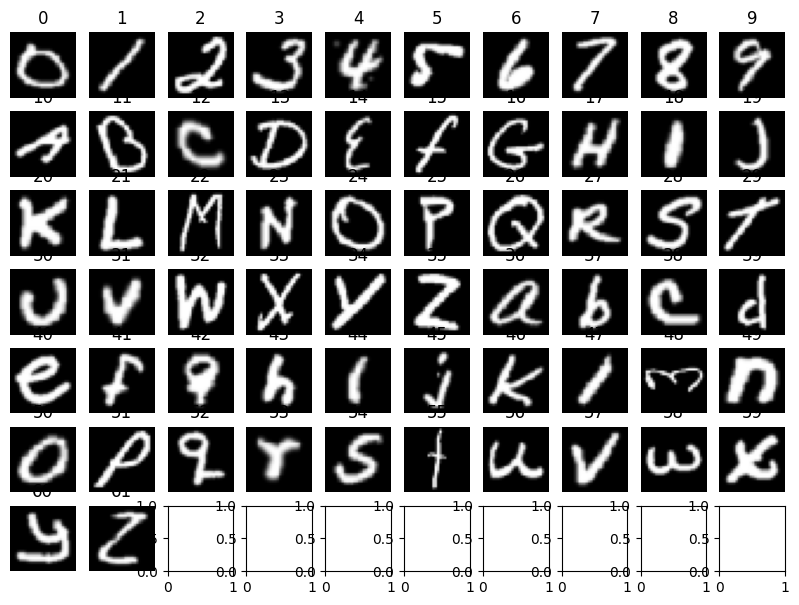

In [38]:
# Load data

# Extract the training split as images and labels
image, label = emnist.extract_training_samples('byclass')

# Add columns for each pixel value (28x28 = 784 columns)
train = pd.DataFrame()

# Add a column with the image data as a 28x28 array
train['image'] = list(image)
train['image_flat'] = train['image'].apply(lambda x: np.array(x).reshape(-1))

# Add a column showing the label
train['label'] = label

# Convert labels to characters
class_label = np.array([int_to_char(l) for l in label])

# Add a column with the character corresponding to the label
train['class'] = class_label

# Repeat for the test split
image, label = emnist.extract_test_samples('byclass')
class_label = np.array([int_to_char(l) for l in label])
valid = pd.DataFrame()
valid['image'] = list(image)
valid['image_flat'] = valid['image'].apply(lambda x: np.array(x).reshape(-1))
valid['label'] = label
valid['class'] = class_label


# Get the first row for each label
firsts = train.groupby('label').first().reset_index()

# Build a plot with the first image for each label
fig, ax = plt.subplots(7, 10, figsize=(10, 7))
for i in range(62):
    ax[i//10, i%10].imshow(firsts['image'][i], cmap='gray')
    ax[i//10, i%10].axis('off')
    ax[i//10, i%10].set_title(firsts['label'][i])

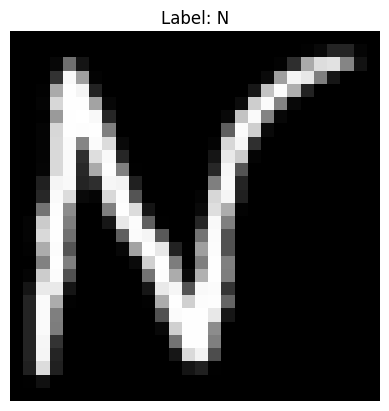

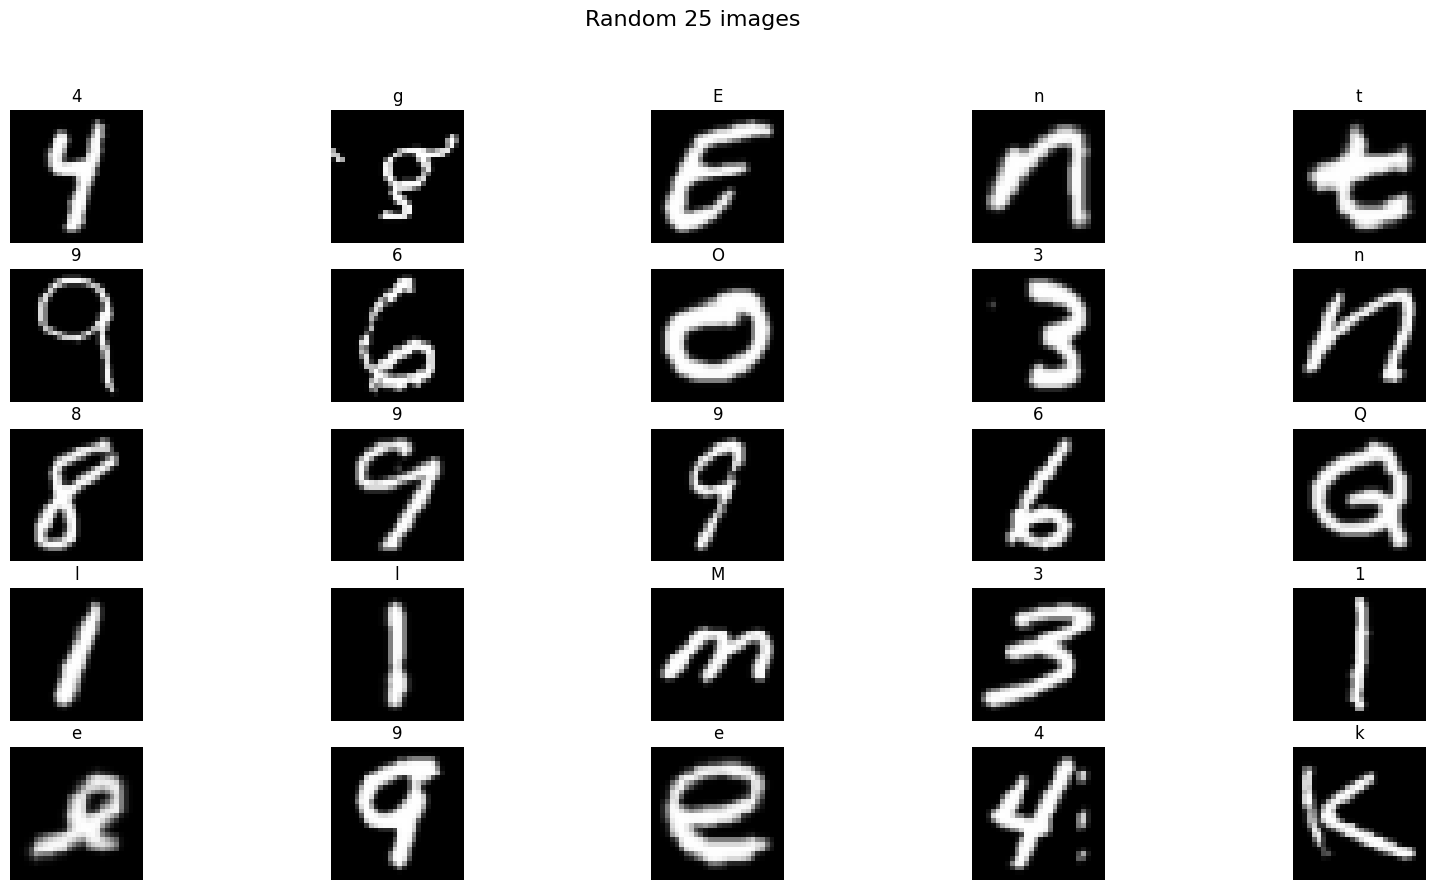

In [25]:
# Using the helper functions

# Plot a random image from the training set
index = np.random.randint(0, len(train))
show_image(train.iloc[index])

# Show a random set of 25 images in a 5x5 grid
show_grid(train.sample(25), title='Random 25 images')

# Show the first 25 images in a 5x5 grid
# show_grid(train[:25], title='First 25 images')

# Isn't it nice to have a helper function to do this for you?

In [ ]:
display(train)

#Exploratory analysis

#Quick Descriptive statistics

#Get list of column name
print(train.columns. values. tolist())

#Print first 4 rows
#print(raw_train.head())
display(train.head())

#Identify number of rows and columns
print(train.shape)
print(valid.shape)

#Identify column types
column_types = train.dtypes
print(column_types)

filtered_train = train[train['class'] == "0"]

In [301]:
display(valid)

missing_values = train.isnull().sum()
print(missing_values)

missing_values2 = valid.isnull().sum()
print(missing_values2)



missing_values3 = test_dataset.isnull().sum()
print(missing_values3)


,image,image_flat,label,class,label_trim,class_trim
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",18,I,None,None
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a,a,a
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,None,None
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,3,3,3
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",33,X,X,X
...,...,...,...,...,...,...
116318,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,7,7,7
116319,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",55,t,t,t
116320,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,S,S,S
116321,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,None,None


image              0
image_flat         0
label              0
class              0
class_bin          0
label_trim    127931
class_trim    127931
dtype: int64
image             0
image_flat        0
label             0
class             0
label_trim    21274
class_trim    21274
dtype: int64
image             0
image_flat        0
label             0
class             0
class_bin     11560
dtype: int64


In [48]:
# 
symbols_list = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

mask_train = train['class'].apply(lambda x: x in symbols_list)
train_01 = train[mask_train]
train_01.reset_index(drop=True, inplace=True)

mask_valid = valid['class'].apply(lambda x: x in symbols_list)
valid_01 = valid[mask_valid]
valid_01.reset_index(drop=True, inplace=True)



# Create a dictionary for performance metrics
metrics_dict = {}

# show_grid(train_01[:25], title="First 25 images of 0's and 1's")

In [27]:
# Subset `train` and `valid` to only include 0s and 1s
symbols_list2 = ['0', '1']

mask_train = train['class'].apply(lambda x: x in symbols_list2)
train_01 = train[mask_train]
train_01.reset_index(drop=True, inplace=True)

mask_valid = valid['class'].apply(lambda x: x in symbols_list2)
valid_01 = valid[mask_valid]
valid_01.reset_index(drop=True, inplace=True)



# Create a dictionary for performance metrics
metrics_dict = {}

# show_grid(train_01[:25], title="First 25 images of 0's and 1's")

In [54]:
 #(OPTIONAL) We can define all the metrics we want to track in a dictionary

#Note, the provided code was set up for a binary classifier. I have created an additional dictionary below for multi-class classification

metrics_dict = {
    '0_vs_1' : { # task name (0 vs 1 classifier)
        'logistic_regression': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'xgboost': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'random_forest': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    },
    'multi-class classification' : { # multi-class classification
        'logistic_regression': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'xgboost': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'random_forest': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

In [29]:
# Classification on `emnist`


### Investigate subsets

#On which classes does the model perform well? Poorly? Evaluate again, excluding easily confused symbols (such as 'O' and '0').

### Improve performance

#Brainstorm for improving the performance. This could include trying different architectures, adding more layers, changing the loss function, or using data augmentation techniques.

In [ ]:
#Question #1- Choose a model

# XGBoost

#THIS PART OF THE CODE TAKES FOREVER TO RUN. DO NOT RUN UNLESS NEEDED!!!!!

task = 'multi-class classification' #this needs to match the string used in the dictionary
model_name = 'xgboost'

# Initialize XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

# Train and evaluate model
xgb_clf.fit(train_01['image_flat'].tolist(), train_01['label'])
y_pred = xgb_clf.predict(valid_01['image_flat'].tolist())






In [87]:
# Calculate performance metrics- the average needs to be set to "macro" as this is a multi-class classification problem
acc = accuracy_score(valid_01['label'], y_pred)
prec = precision_score(valid_01['label'], y_pred, average='macro')
rec = recall_score(valid_01['label'], y_pred, average='macro')
f1 = f1_score(valid_01['label'], y_pred, average='macro')
cm = confusion_matrix(valid_01['label'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Performance Metrics: xgboost

,accuracy,precision,recall,f1
0,0.821892,0.721661,0.674658,0.688113


# Confusion Matrix: xgboost

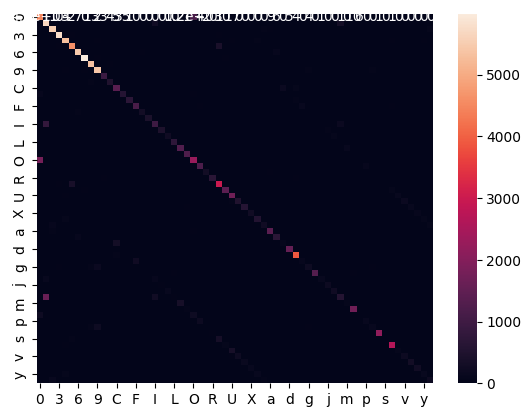

In [88]:
display_metrics_multiclass(task, model_name, metrics_dict)

In [ ]:

#Hyper-parameter tuning

from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Initialize XGBoost classifier
xgb_clf = XGBClassifier(random_state=42)

# Initialize GridSearchCV
grid_search = GridSearchCV(estimator=xgb_clf, param_grid=param_grid, cv=3, scoring='accuracy')

# Perform grid search
grid_search.fit(train_01['image_flat'].tolist(), train_01['label'])

# Get best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

# Train final model with best parameters
final_model = XGBClassifier(**best_params, random_state=42)
final_model.fit(train_01['image_flat'].tolist(), train_01['label'])

# Evaluate final model
accuracy = final_model.score(valid_01['image_flat'].tolist(), valid_01['label'])
print("Validation Accuracy:", accuracy)


In [ ]:

#Function to identify the labels which have the poorest classification

def find_misclassifications_above_threshold(confusion_matrix, symbols_list, threshold=300):
    misclassifications = []
    for true_label_index in range(len(symbols_list)):
        for predicted_label_index in range(len(symbols_list)):
            if true_label_index != predicted_label_index:
                count = confusion_matrix[true_label_index, predicted_label_index]
                if count > threshold:
                    true_label = symbols_list[true_label_index]
                    predicted_label = symbols_list[predicted_label_index]
                    misclassifications.append((true_label, predicted_label, count))
    return misclassifications

misclassifications = find_misclassifications_above_threshold(cm, symbols_list, threshold=300)

print("Letters with greater than 300 misclassifications:")
for true_label, predicted_label, count in misclassifications:
    print(f"True label '{true_label}' predicted as '{predicted_label}': {count} times")


In [ ]:
#Next I will remove the poorest classified labels which include zero, O, l and 1, and I
symbols_trim = ['2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'J', 'K', 'L', 'M', 'N','P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
          'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'j', 'k', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']

new_label_function = lambda x: symbols_trim.index(x)

#Create another column with problem labels removed
train['class_trim'] = train['class'].where(train['class'].astype(str).str.contains('|'.join(symbols_trim)), None)
train_clean = train[train['class_trim'].notnull()]
train_clean['label_trim'] = train_clean['class'].apply(new_label_function)

#Create another column with problem labels removed
valid['class_trim'] = valid['class'].where(valid['class'].astype(str).str.contains('|'.join(symbols_trim)), None)
valid_clean = valid[valid['class_trim'].notnull()]
valid_clean['label_trim'] = valid_clean['class'].apply(new_label_function)

display(train_clean)
display(valid_clean)

In [274]:

mask_train_trim = train_clean['class_trim'].apply(lambda x: x in symbols_trim)
train_trim = train_clean[mask_train_trim]
train_trim.reset_index(drop=True, inplace=True)

mask_valid_trim = valid_clean['class_trim'].apply(lambda x: x in symbols_trim)
valid_trim = valid_clean[mask_valid_trim]
valid_trim.reset_index(drop=True, inplace=True)



In [275]:
task = 'multi-class classification' #this needs to match the string used in the dictionary
model_name = 'xgboost'

# Initialize XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

# Train and evaluate model
xgb_clf.fit(train_trim['image_flat'].tolist(), train_trim['label_trim'])
y_pred_trim = xgb_clf.predict(valid_trim['image_flat'].tolist())


In [250]:

#There are no aberrant symbols outside of the symbols_trim

def examine_aberrant_symbols(df_column, symbols_trim):
    """
    Examine if there are aberrant symbols in a DataFrame column.
    
    Parameters:
        df_column (pandas.Series): The column of the DataFrame to be examined.
        symbols_trim (list): A list of symbols that are allowed.
    
    Returns:
        list: A list of tuples containing the index and value of aberrant symbols found in the column.
    """
    aberrant_symbols = []
    for index, value in df_column.items():
        for char in value:
            if char not in symbols_trim:
                aberrant_symbols.append((index, value))
                break  # Stop checking the rest of the characters once an aberrant symbol is found
    return aberrant_symbols


# Assuming 'df' is your DataFrame and 'column_name' is the column you want to examine
column_name = 'your_column_name'
aberrant_symbols_list = examine_aberrant_symbols(train_clean["label_trim"], symbols_trim)
print(aberrant_symbols_list)


[]


In [241]:
print(train_trim['label'].unique())
print(valid_trim['label'].unique())

[35 36  6  3 22 38  5  9  4  7 56 29 40 55 57 43 32 15 26  2 28  8 49 12
 59 41 46 23 51 31 45 39 11 54 19 20 61 25 37 52 58 14 34 30 27 16 33 21
 60 48 53 13 10 50 17 42]
[36  3 33 30 40  5  8  2  4  7 32 60 46 59 12 37 53 15  9 38 43 19 55  6
 58 41 20 29 28 31 42 39 25 49 35 14 57 34 26 61 11 13 27 51 23 10 22 56
 48 52 16 17 54 21 50 45]


In [ ]:
# Calculate performance metrics for the trimmed labels- the average needs to be set to "macro" as this is a multi-class classification problem
acc = accuracy_score(valid_trim['label'], y_pred_trim)
prec = precision_score(valid_trim['label'], y_pred_trim, average='macro')
rec = recall_score(valid_trim['label'], y_pred_trim, average='macro')
f1 = f1_score(valid_trim['label'], y_pred_trim, average='macro')
cm = confusion_matrix(valid_trim['label'], y_pred_trim)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

In [ ]:
#1. Create a column for whether each row is a digit or a letter

def class_cat(class_label):
    if class_label.isdigit():
        return "digit"
    else:
        return "letter"

    
train["class_bin"]= train["class"].apply(class_cat)

display(train)

In [ ]:
#2. Choose an evaluation metric- eg. f1, accuracy, AUC, etc.

#I will choose the f1 evaluation metric to compare models

In [ ]:
#3. Choose several candidate models to train

#Logistic regression, neural networks, xgboost, random forest (try them all)


In [ ]:
merged_emnist = pd.concat([train, valid], axis=0)
display(merged_emnist)

In [167]:
display(merged_emnist)
display(train_bin)

,image,image_flat,label,class,class_bin
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",35,Z,letter
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",36,a,letter
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",6,6,digit
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",3,3,digit
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",22,M,letter
...,...,...,...,...,...
116318,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,7,NaN
116319,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",55,t,NaN
116320,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",28,S,NaN
116321,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",0,0,NaN


,image,image_flat,label,class,class_bin


In [177]:
#4. Divide data to reserve a validation set that will NOT be used in training/testing

#I will use a 70/15/15 ratio for train/validation/and test datasets

#axis=0 means vertical stacking
merged_emnist = pd.concat([train, valid], axis=0)

# Shuffle the rows of the merged DataFrame
merged_emnist_shuffled = merged_emnist.sample(frac=1, random_state=42)


# Calculate sizes for train, validation, and test sets

#set aside a test set of 10% of total data
total_train_size = int(0.90 * len(merged_emnist_shuffled))
test_size = len(merged_emnist_shuffled) - total_train_size


total_train_dataset = merged_emnist_shuffled.iloc[:total_train_size]
test_dataset = merged_emnist_shuffled.iloc[total_train_size:]


# Print the sizes of the resulting sets
print("Total Training set size:", len(total_train_dataset))
print("Test set size:", len(test_dataset))


Total Training set size: 732829
Test set size: 81426


In [178]:

#Create from the total training data, two train sets of 30%, and 2 test sets of 15%

train1_size = int(0.3 * len(total_train_dataset))
val1_size = int(0.15 * len(total_train_dataset))
train2_size = int(0.3 * len(total_train_dataset))
val2_size = int(0.15 * len(total_train_dataset))

# Split the shuffled DataFrame into train, validation, and test sets

# First split for total_train_dataset
train1_dataset = total_train_dataset.iloc[:train1_size]
val1_dataset = total_train_dataset.iloc[train1_size:train1_size+val1_size]

# Second split for total_train_dataset (to create train2_dataset and val2_dataset)
train2_dataset = total_train_dataset.iloc[train1_size+val1_size:train1_size+val1_size+train2_size]
val2_dataset = total_train_dataset.iloc[train1_size+val1_size+train2_size:]

# Print the sizes of the resulting sets
print("Train1 set size:", len(train1_dataset))
print("Val1 set size:", len(val1_dataset))
print("Train2 set size:", len(train2_dataset))
print("Val2 set size:", len(val2_dataset))



Train1 set size: 219848
Val1 set size: 109924
Train2 set size: 219848
Val2 set size: 183209


In [ ]:
display(train1_dataset)

In [181]:


#Filter data so includes only the rows including "digit" and "letter", which should be all observations in training and validation
#set based on this particular dataset

symbols_bin = ['digit', 'letter']

mask_train1_dataset = train1_dataset['class_bin'].apply(lambda x: x in symbols_bin)
train1_bin = train1_dataset[mask_train1_dataset]
train1_bin.reset_index(drop=True, inplace=True)

mask_valid1_dataset = val1_dataset['class_bin'].apply(lambda x: x in symbols_bin)
valid1_bin = val1_dataset[mask_valid1_dataset]
valid1_bin.reset_index(drop=True, inplace=True)


#Set set of train and test
symbols_bin = ['digit', 'letter']

mask_train2_dataset = train2_dataset['class_bin'].apply(lambda x: x in symbols_bin)
train2_bin = train2_dataset[mask_train2_dataset]
train2_bin.reset_index(drop=True, inplace=True)

mask_valid2_dataset = val2_dataset['class_bin'].apply(lambda x: x in symbols_bin)
valid2_bin = val2_dataset[mask_valid2_dataset]
valid2_bin.reset_index(drop=True, inplace=True)


In [182]:

display(train1_bin)

,image,image_flat,label,class,class_bin
0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,7,digit
1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",57,v,letter
2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",9,9,digit
3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,7,digit
4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",47,l,letter
...,...,...,...,...,...
188527,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",50,o,letter
188528,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12,C,letter
188529,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",47,l,letter
188530,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",37,b,letter


In [183]:
metrics_dict = {
    'digit_vs_letter' : { # task name (0 vs 1 classifier)
        'logistic_regression': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'xgboost': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'random_forest': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        },
        'neural_network': {
            'confusion_matrix': [],
            'accuracy': [],
            'precision': [],
            'recall': [],
            'f1': []
        }
    }
}

In [188]:
#RandomForest For 1st Set of Training/Test Data

#I specified a "positive" label (1) as a "letter"


task = 'digit_vs_letter'
model_name = 'random_forest'
metrics_dict[task] = {model_name: {}}

# Initialize random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train and evaluate model
rf_clf.fit(train1_bin['image_flat'].tolist(), train1_bin['class_bin'])
y_pred = rf_clf.predict(valid1_bin['image_flat'].tolist())

# Calculate performance metrics
acc = accuracy_score(valid1_bin['class_bin'], y_pred)
prec = precision_score(valid1_bin['class_bin'], y_pred, pos_label='letter')
rec = recall_score(valid1_bin['class_bin'], y_pred, pos_label='letter')
f1 = f1_score(valid1_bin['class_bin'], y_pred, pos_label='letter')
cm = confusion_matrix(valid1_bin['class_bin'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: random_forest

,accuracy,precision,recall,f1
0,0.888129,0.900246,0.874757,0.887318


# Confusion Matrix: random_forest

,predicted 0,predicted 1
actual 0,42109,4591
actual 1,5932,41432


In [190]:
#Classifier: Logistic Regression for First Set of Training/Test Data
task = 'digit_vs_letter'
model_name = 'logistic_regression'

# Initialize logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Scale the data
# When running without scaling the data, the model does not converge
scaler = StandardScaler()
train1_scaled = scaler.fit_transform(train1_bin['image_flat'].tolist())
valid1_scaled = scaler.transform(valid1_bin['image_flat'].tolist())

# Initialize logistic regression classifier
lr_clf = LogisticRegression(max_iter=1000, random_state=42)

# Train and evaluate model
lr_clf.fit(train1_scaled, train1_bin['class_bin'])
y_pred = lr_clf.predict(valid1_scaled)

# Calculate performance metrics
acc = accuracy_score(valid1_bin['class_bin'], y_pred)
prec = precision_score(valid1_bin['class_bin'], y_pred, pos_label='letter')
rec = recall_score(valid1_bin['class_bin'], y_pred, pos_label='letter')
f1 = f1_score(valid1_bin['class_bin'], y_pred, pos_label='letter')
cm = confusion_matrix(valid1_bin['class_bin'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: logistic_regression

,accuracy,precision,recall,f1
0,0.73703,0.747506,0.721434,0.734239


# Confusion Matrix: logistic_regression

,predicted 0,predicted 1
actual 0,35158,11542
actual 1,13194,34170


In [ ]:
#XG Boost for 1st set of Train/Test Data

#The XG Boost did not like the outcome being stored as a string, so I converted to a numeric value, where
#letter=1 and digit = 0

#XGBoost
task = 'digit_vs_letter'
model_name = 'xgboost'

train1_bin['class_bin'] = train1_bin['class_bin'].replace({'letter': 1, 'digit': 0})
valid1_bin['class_bin'] = valid1_bin['class_bin'].replace({'letter': 1, 'digit': 0})


# Initialize XGBoost classifier
xgb_clf = XGBClassifier(n_estimators=100, random_state=42)

# Train and evaluate model
xgb_clf.fit(train1_bin['image_flat'].tolist(), train1_bin['class_bin'])
y_pred = xgb_clf.predict(valid1_bin['image_flat'].tolist())

# Calculate performance metrics
acc = accuracy_score(valid1_bin['class_bin'], y_pred)
prec = precision_score(valid1_bin['class_bin'], y_pred)
rec = recall_score(valid1_bin['class_bin'], y_pred)
f1 = f1_score(valid1_bin['class_bin'], y_pred)
cm = confusion_matrix(valid1_bin['class_bin'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

In [ ]:
#  Neural Network for First Set of Training/Test Data
task = 'digit_vs_letter'
model_name = 'neural_network'

# Set random seed for reproducibility
tf.random.set_seed(42)

train1_bin['class_bin'] = train1_bin['class_bin'].replace({'letter': 1, 'digit': 0})
valid1_bin['class_bin'] = valid1_bin['class_bin'].replace({'letter': 1, 'digit': 0})

# Convert data to tensor
train_images = np.array(train1_bin['image'])
train_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), train_images)))
train_images = train_images / 255.0
train_labels = np.array(train1_bin['class_bin'])
valid_images = np.array(valid1_bin['image'])
valid_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), valid_images)))
valid_images = valid_images / 255.0
valid_labels = np.array(valid1_bin['class_bin'])

# Initialize neural network model
model = Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model, specifying the optimizer, loss function, and metrics 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model, saving the history of the training process
history = model.fit(train_images, train_labels, epochs=10, validation_data=(valid_images, valid_labels))

# Evaluate the model
loss, acc = model.evaluate(valid_images, valid_labels)
y_pred = (model.predict(valid_images) > 0.5).astype(int).flatten()

# Calculate performance metrics
acc = accuracy_score(valid1_bin['class_bin'], y_pred)
prec = precision_score(valid1_bin['class_bin'], y_pred)
rec = recall_score(valid1_bin['class_bin'], y_pred)
f1 = f1_score(valid1_bin['class_bin'], y_pred)
cm = confusion_matrix(valid1_bin['class_bin'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Plot the training and validation accuracy during the training of the model
plot_accuracy(history)
plot_loss(history)

In [215]:
# create an empty DataFrame to hold the results
results_df = pd.DataFrame()

# iterate over the keys in the metrics_dict
for key in metrics_dict:
    
    # create a new DataFrame to hold the results for this key
    df = pd.DataFrame.from_dict(metrics_dict[key], orient='index')
    
    # add a new row to the DataFrame indicating the model name and metric type
    df = df.assign(model=key, metric=df.index)
    
    # set the index to the 'model' and 'metric' columns
    df = df.set_index(['model', 'metric'])
    
    # append the results to the main DataFrame
    results_df = pd.concat([results_df, df])

# display the resulting table
display(results_df)

,,accuracy,precision,recall,f1,confusion_matrix
model,metric,,,,,
digit_vs_letter,random_forest,0.889544,0.902829,0.876138,0.889283,"[[70015, 7496], [9846, 69646]]"


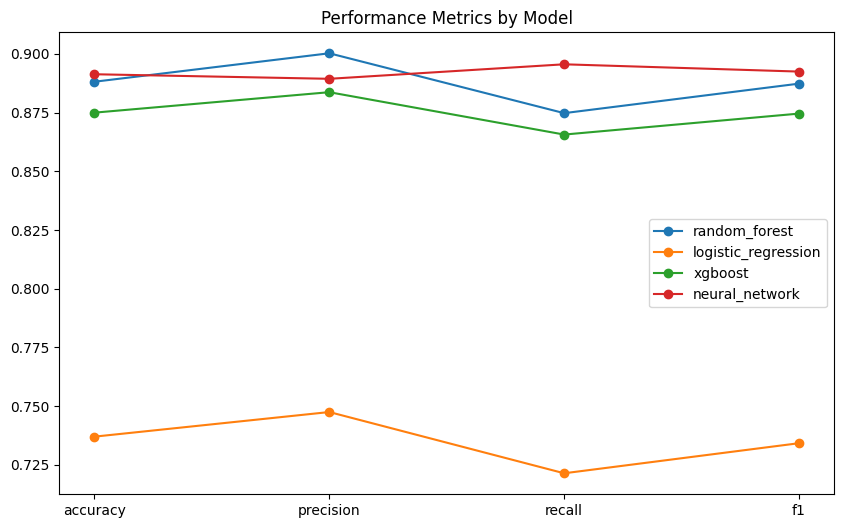

In [210]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# set the x-axis labels
labels = ['accuracy', 'precision', 'recall', 'f1']

# iterate over the models in the metrics_dict
for i, model in enumerate(metrics_dict['digit_vs_letter'].keys()):
    # extract the metric values for this model
    values = [metrics_dict['digit_vs_letter'][model][label] for label in labels]
    
    # plot the values as a line
    ax.plot(labels, values, label=model, marker='o', color=colors[i])

    
# add a legend and title
ax.legend()
ax.set_title('Performance Metrics by Model')

# show the plot
plt.show()

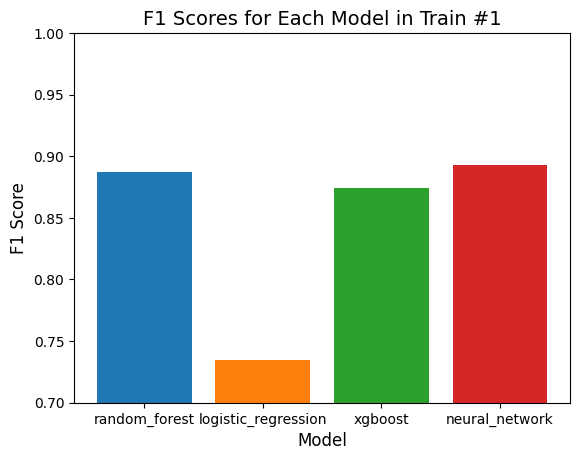

In [212]:
models = ['random_forest', 'logistic_regression',"xgboost","neural_network"]
accuracies = [metrics_dict['digit_vs_letter'][model]['f1'] for model in models]

plt.bar(models, accuracies, color=colors)
plt.title('F1 Scores for Each Model in Train #1', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim([0.7, 1.0])
plt.show()


In [ ]:
#hyper Parameter searching for Train #1?

In [213]:
#Will pick the neural network and random forest to assess train/test split #2

#RandomForest For 2st Set of Training/Test Data

#I specified a "positive" label (1) as a "letter"


task = 'digit_vs_letter'
model_name = 'random_forest'
metrics_dict[task] = {model_name: {}}

# Initialize random forest classifier
rf_clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train and evaluate model
rf_clf.fit(train2_bin['image_flat'].tolist(), train2_bin['class_bin'])
y_pred = rf_clf.predict(valid2_bin['image_flat'].tolist())

# Calculate performance metrics
acc = accuracy_score(valid2_bin['class_bin'], y_pred)
prec = precision_score(valid2_bin['class_bin'], y_pred, pos_label='letter')
rec = recall_score(valid2_bin['class_bin'], y_pred, pos_label='letter')
f1 = f1_score(valid2_bin['class_bin'], y_pred, pos_label='letter')
cm = confusion_matrix(valid2_bin['class_bin'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Performance Metrics: random_forest

,accuracy,precision,recall,f1
0,0.889544,0.902829,0.876138,0.889283


# Confusion Matrix: random_forest

,predicted 0,predicted 1
actual 0,70015,7496
actual 1,9846,69646


In [ ]:
#  Neural Network for 2nd Set of Training/Test Data
task = 'digit_vs_letter'
model_name = 'neural_network'

# Set random seed for reproducibility
tf.random.set_seed(42)

train2_bin['class_bin'] = train2_bin['class_bin'].replace({'letter': 1, 'digit': 0})
valid2_bin['class_bin'] = valid2_bin['class_bin'].replace({'letter': 1, 'digit': 0})

# Convert data to tensor
train_images = np.array(train2_bin['image'])
train_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), train_images)))
train_images = train_images / 255.0
train_labels = np.array(train2_bin['class_bin'])
valid_images = np.array(valid2_bin['image'])
valid_images = np.array(list(map(lambda x: np.reshape(x, (28, 28, 1)), valid_images)))
valid_images = valid_images / 255.0
valid_labels = np.array(valid2_bin['class_bin'])

# Initialize neural network model
model = Sequential([
    keras.layers.InputLayer(input_shape=(28, 28, 1)),
    keras.layers.Flatten(),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(1, activation='sigmoid')
])

# Compile the model, specifying the optimizer, loss function, and metrics 
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model, saving the history of the training process
history = model.fit(train_images, train_labels, epochs=10, validation_data=(valid_images, valid_labels))

# Evaluate the model
loss, acc = model.evaluate(valid_images, valid_labels)
y_pred = (model.predict(valid_images) > 0.5).astype(int).flatten()

# Calculate performance metrics
acc = accuracy_score(valid2_bin['class_bin'], y_pred)
prec = precision_score(valid2_bin['class_bin'], y_pred)
rec = recall_score(valid2_bin['class_bin'], y_pred)
f1 = f1_score(valid2_bin['class_bin'], y_pred)
cm = confusion_matrix(valid2_bin['class_bin'], y_pred)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {'accuracy': acc,
                                  'precision': prec,
                                  'recall': rec,
                                  'f1': f1,
                                  'confusion_matrix': cm}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Plot the training and validation accuracy during the training of the model
plot_accuracy(history)
plot_loss(history)

neural_network_model2= model

In [217]:
# create an empty DataFrame to hold the results
results_df = pd.DataFrame()

# iterate over the keys in the metrics_dict
for key in metrics_dict:
    
    # create a new DataFrame to hold the results for this key
    df = pd.DataFrame.from_dict(metrics_dict[key], orient='index')
    
    # add a new row to the DataFrame indicating the model name and metric type
    df = df.assign(model=key, metric=df.index)
    
    # set the index to the 'model' and 'metric' columns
    df = df.set_index(['model', 'metric'])
    
    # append the results to the main DataFrame
    results_df = pd.concat([results_df, df])

# display the resulting table
display(results_df)

accuracy  precision    recall        f1  \
model           metric                                                    
digit_vs_letter random_forest   0.889544   0.902829  0.876138  0.889283   
                neural_network  0.894155   0.912776  0.874516  0.893236   

                                              confusion_matrix  
model           metric                                          
digit_vs_letter random_forest   [[70015, 7496], [9846, 69646]]  
                neural_network  [[70868, 6643], [9975, 69517]]

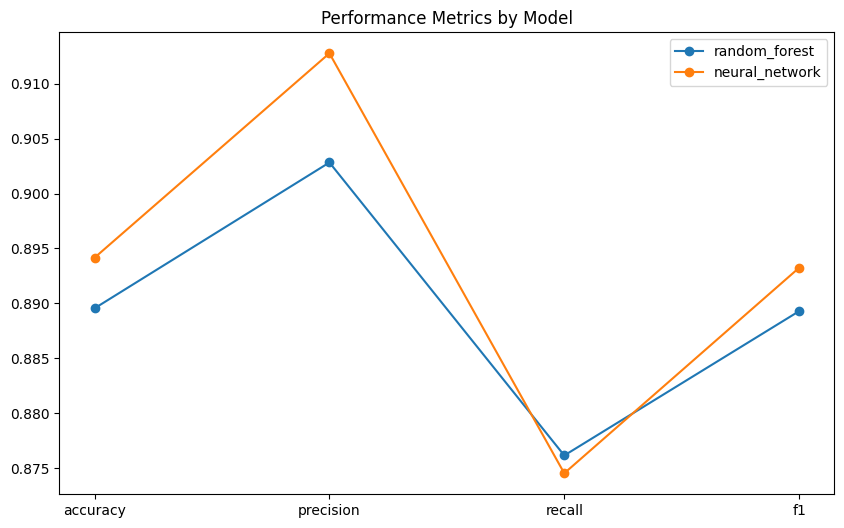

In [218]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

# create a new figure
fig, ax = plt.subplots(figsize=(10, 6))

# set the x-axis labels
labels = ['accuracy', 'precision', 'recall', 'f1']

# iterate over the models in the metrics_dict
for i, model in enumerate(metrics_dict['digit_vs_letter'].keys()):
    # extract the metric values for this model
    values = [metrics_dict['digit_vs_letter'][model][label] for label in labels]
    
    # plot the values as a line
    ax.plot(labels, values, label=model, marker='o', color=colors[i])

    
# add a legend and title
ax.legend()
ax.set_title('Performance Metrics by Model')

# show the plot
plt.show()

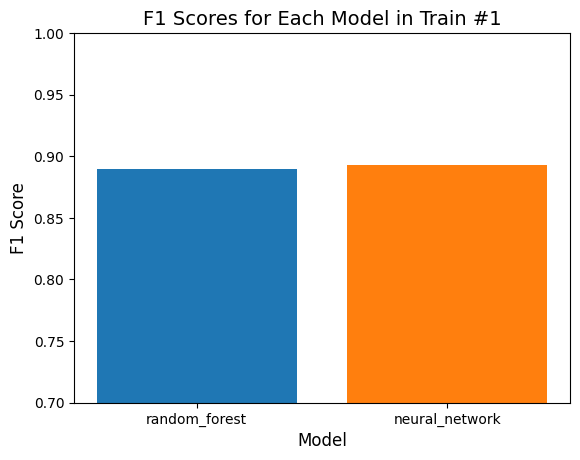

In [220]:
models = ['random_forest',"neural_network"]
accuracies = [metrics_dict['digit_vs_letter'][model]['f1'] for model in models]

plt.bar(models, accuracies, color=colors)
plt.title('F1 Scores for Each Model in Train #1', fontsize=14)
plt.xlabel('Model', fontsize=12)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.ylim([0.7, 1.0])
plt.show()


In [321]:
display(test_dataset)
missing_values3 = test_dataset.isnull().sum()
print(missing_values3)

# Check for missing values in the class column
missing_values_class_bin = test_dataset['class_bin'].isnull().sum()
#print("Missing values in the class column:", missing_values_class)
print("Missing values in the class_bin column:", missing_values_class_bin)




,image,image_flat,label,class,class_bin2,class_bin
643018,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",47,l,1,1
226830,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,7,1,0
762,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",43,h,1,1
540545,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,1,0
50800,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",27,R,1,1
...,...,...,...,...,...,...
259178,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",17,H,1,1
365838,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",24,O,1,1
131932,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,1,0
671155,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",53,r,1,1


image         0
image_flat    0
label         0
class         0
class_bin2    0
class_bin     0
dtype: int64
Missing values in the class_bin column: 0


In [313]:
test_dataset["class_bin"]= test_dataset["class"].apply(class_cat)
display(test_dataset.head())


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_50010/3190046585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset["class_bin"]= test_dataset["class"].apply(class_cat)


,image,image_flat,label,class,class_bin2,class_bin
643018,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",47,l,1,letter
226830,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",7,7,1,digit
762,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",43,h,1,letter
540545,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",1,1,1,digit
50800,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",27,R,1,letter


In [319]:
import numpy as np

#THIS CODE RAN

task = 'digit_vs_letter'
model_name = 'neural_network'

# Assuming test_dataset contains the test data

# Convert class labels to numeric format
test_dataset['class_bin'] = test_dataset['class_bin'].replace({'letter': 1, 'digit': 0})

# Assign the converted labels to test_labels_encoded
test_labels_encoded = test_dataset['class_bin'].astype(np.float32)

# Check the labels to identify any unexpected values
print(np.unique(test_labels_encoded))

# Ensure that all labels are now numeric
print(test_labels_encoded.dtype)

# Evaluate the model on the test dataset
loss, accuracy = neural_network_model2.evaluate(test_images, test_labels_encoded)
print("Independent Dataset Loss:", loss)
print("Independent Dataset Accuracy:", accuracy)

# Make predictions on the independent dataset
y_pred_independent = (neural_network_model2.predict(test_images) > 0.5).astype(int).flatten()


/var/folders/k2/h7t5byyn0_sc57mcln13ql6w0000gn/T/ipykernel_50010/3437201363.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dataset['class_bin'] = test_dataset['class_bin'].replace({'letter': 1, 'digit': 0})


[0. 1.]
float32
2545/2545 [==============================] - 1s 346us/step - loss: 0.2429 - accuracy: 0.8962
Independent Dataset Loss: 0.24291685223579407
Independent Dataset Accuracy: 0.896187961101532
2545/2545 [==============================] - 1s 312us/step


# Performance Metrics: neural_network

,accuracy,precision,recall,f1
0,0.896188,0.9152,0.875668,0.894998


# Confusion Matrix: neural_network

,predicted 0,predicted 1
actual 0,36948,3338
actual 1,5115,36025


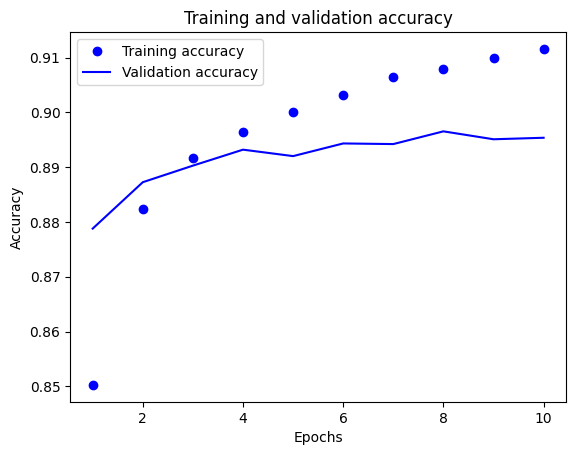

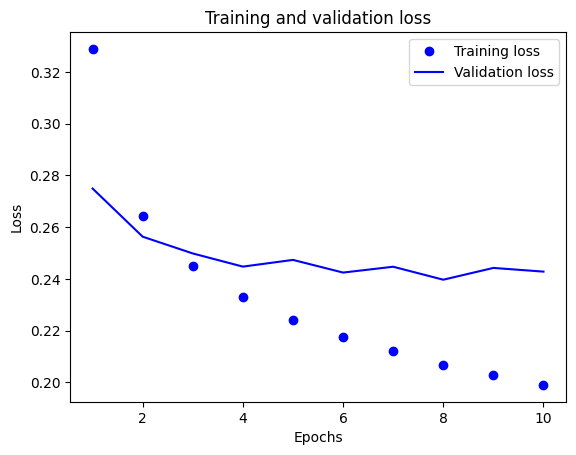

In [320]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

# Assuming you have already defined task and model_name variables

# Calculate performance metrics for the independent dataset
acc_independent = accuracy_score(test_labels_encoded, y_pred_independent)
prec_independent = precision_score(test_labels_encoded, y_pred_independent)
rec_independent = recall_score(test_labels_encoded, y_pred_independent)
f1_independent = f1_score(test_labels_encoded, y_pred_independent)
cm_independent = confusion_matrix(test_labels_encoded, y_pred_independent)

# Store performance metrics in dictionary
metrics_dict[task][model_name] = {
    'accuracy': acc_independent,
    'precision': prec_independent,
    'recall': rec_independent,
    'f1': f1_independent,
    'confusion_matrix': cm_independent
}

# Display performance metrics
display_metrics(task, model_name, metrics_dict)

# Plot the training and validation accuracy during the training of the model
plot_accuracy(history)
plot_loss(history)


In [298]:
# Print confusion matrix
print("Confusion Matrix:")
print(cm_independent)

# Inspect some example predictions
for i in range(10):
    print(f"True Label: {test_labels_encoded[i]}, Predicted Label: {y_pred_independent[i]}")



Confusion Matrix:
[[42063 39363]
 [    0     0]]
True Label: 0.0, Predicted Label: 1
True Label: 0.0, Predicted Label: 0
True Label: 0.0, Predicted Label: 1
True Label: 0.0, Predicted Label: 0
True Label: 0.0, Predicted Label: 1
True Label: 0.0, Predicted Label: 0
True Label: 0.0, Predicted Label: 0
True Label: 0.0, Predicted Label: 1
True Label: 0.0, Predicted Label: 0
True Label: 0.0, Predicted Label: 1
